In [ ]:
import zipfile
import os
import shutil
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import classification_report


In [ ]:
import zipfile
import os

# Paths to your zip files
zip_paths = [
    "/content/randomclass2.zip",
    "/content/3birds.zip"
]

# Unzipping function
def unzip_files(zip_paths, extract_to_base):
    for zip_path in zip_paths:
        # Get the folder name based on the zip file name
        folder_name = os.path.splitext(os.path.basename(zip_path))[0]
        extract_to = os.path.join(extract_to_base, folder_name)

        os.makedirs(extract_to, exist_ok=True)
        print(f"Unzipping {zip_path} to {extract_to}...")

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"Finished unzipping {zip_path} to {extract_to}")

# Unzip all files to separate directories for each bird
extracted_base_dir = "/content/extracted_images"
unzip_files(zip_paths, extracted_base_dir)


Unzipping /content/randomclass2.zip to /content/extracted_images/randomclass2...
Finished unzipping /content/randomclass2.zip to /content/extracted_images/randomclass2
Unzipping /content/3birds.zip to /content/extracted_images/3birds...
Finished unzipping /content/3birds.zip to /content/extracted_images/3birds


In [ ]:
# Function to split and organize datasets
def split_and_organize_datasets(base_extracted_dir, split_base_dir, test_size=0.2, val_size=0.2):
    if os.path.exists(split_base_dir):
        shutil.rmtree(split_base_dir)
    os.makedirs(split_base_dir, exist_ok=True)
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(split_base_dir, split), exist_ok=True)

    for bird_folder in os.listdir(base_extracted_dir):
        bird_dir = os.path.join(base_extracted_dir, bird_folder)
        if not os.path.isdir(bird_dir):
            continue
        images = [img for img in os.listdir(bird_dir) if img.endswith(('.jpg', '.jpeg', '.png'))]
        if len(images) == 0:
            continue
        train_imgs, test_imgs = train_test_split(images, test_size=test_size, random_state=42)
        train_imgs, val_imgs = train_test_split(train_imgs, test_size=val_size, random_state=42)
        for split, imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
            split_dir = os.path.join(split_base_dir, split, bird_folder)
            os.makedirs(split_dir, exist_ok=True)
            for img in imgs:
                shutil.copy(os.path.join(bird_dir, img), os.path.join(split_dir, img))

# Split dataset
split_base_dir = "/content/split_datasets"
split_and_organize_datasets(extracted_base_dir, split_base_dir)


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set directories
train_dir = os.path.join(split_base_dir, 'train')
val_dir = os.path.join(split_base_dir, 'val')
test_dir = os.path.join(split_base_dir, 'test')

# Image size and batch size
img_size = (224, 224)
batch_size = 32

# ImageDataGenerator setup
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Data generators
train_gen = train_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_gen = val_datagen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_gen = test_datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)


Found 1280 images belonging to 2 classes.
Found 320 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [ ]:

# Load the MobileNetV2 model with pre-trained weights
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False


for layer in base_model.layers[-15:]:
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer = tf.keras.regularizers.l2(0.005)

# Create the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.15),
    Dense(train_gen.num_classes, activation='softmax')
])

# Compile the model with label smoothing
model.compile(
    optimizer=Adam(learning_rate=3e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
    metrics=['accuracy']
)



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Train model
epochs = 10
history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.7397 - loss: 2.8402 - val_accuracy: 0.9406 - val_loss: 2.5364
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.9679 - loss: 2.4251 - val_accuracy: 0.9406 - val_loss: 2.4563
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9790 - loss: 2.3409 - val_accuracy: 0.9531 - val_loss: 2.3758
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.9768 - loss: 2.2890 - val_accuracy: 0.9594 - val_loss: 2.3099
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9909 - loss: 2.2128 - val_accuracy: 0.9594 - val_loss: 2.2634
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.9934 - loss: 2.1547 - val_accuracy: 0.9656 - val_loss: 2.1977
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.9958 - loss: 2.0969 - val_accuracy: 0.9719 - val_loss: 2.1260
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.9960 - loss: 2.0481 - val_accuracy: 0.9719 - val_

In [ ]:

average_training_accuracy = sum(history.history['accuracy']) / len(history.history['accuracy'])
print(f"Average Training Accuracy: {average_training_accuracy * 100:.2f}%")

test_loss, test_accuracy = model.evaluate(test_gen, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=-1)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))


Average Training Accuracy: 97.45%
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9782 - loss: 1.9496
Test Accuracy: 95.75%
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step
Classification Report:
              precision    recall  f1-score   support

      3birds       0.93      0.99      0.96       200
randomclass2       0.99      0.92      0.96       200

    accuracy                           0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400



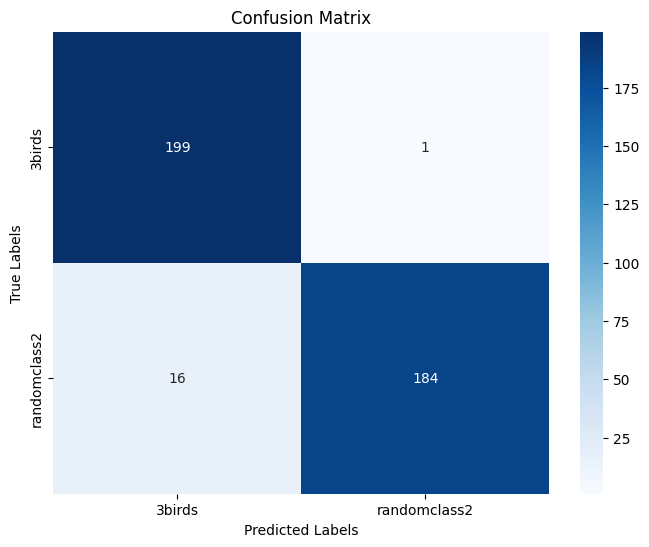

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
model.save("/content/second_model.h5")
from google.colab import files
files.download("/content/second_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>